<a href="https://colab.research.google.com/github/MandbeZ/TFM_sequia/blob/main/notebooks/4_4_Redes_Neuronales__SPI_SPEI(Cluster).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tensorflow==2.1
%pip install keras-tcn
%matplotlib inline

## Importar librerías básicas

In [ ]:
import numpy as np
import pandas as pd
import datetime
import random
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

## Importar librerías de Tensor Flow y Keras

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, LSTM, Input, GRU
from tensorflow.keras import backend as K
from tcn import TCN
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from warnings import simplefilter
simplefilter(action="ignore", category=RuntimeWarning)

## Definición de Funciones

In [ ]:
#Colores para los plot
colores = plt.get_cmap('Set1', 30)

def cargar_datos(archivo, lista_cluster, c):
    data = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/' + archivo,  sep = ',', parse_dates=True)
    estaciones = lista_cluster[lista_cluster['cluster'] == c]
    nom_cols = [col for est in estaciones['id'] for col in data.columns if str(est) in col]
    nom_cols.append('fecha')
    datos = data[nom_cols]
    return datos

'''Llevar la  fecha a índice, configurar como periodo'''
def procesa_datos(data):
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.dropna()
    data = data.set_index('fecha')
    data.index = data.index.to_period('M')
    return data

'''Se normalizan los datos Min-Max: [0,1]'''
def normalizar_datos(data,param):
    return (data - param['min']) / ( param['max'] - param['min'])

'''Dividir el Dataset en Entrenamiento y prueba'''
def dividir_datos(serie, tamanio):
    y_train, y_test = temporal_train_test_split(serie, test_size=tamanio)
    return y_train, y_test

def plotear(x, y, y_pred=None):
  fig, ax = plt.subplots(1,1, figsize=(15,5))
  ax.plot(x, 'o-',  c=colores(1), markersize=3.5, label='Entrenamiento(Train)')
  ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y, 'x-', c=colores(5), markersize=3.5, label='Validación(Test)')
  if y_pred is not None:
    ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y_pred, 'o-', c=colores(8), markersize=3.5, label='Predicción(Pred)')
  ax.legend()

# 1. Cargar los datos de SPI o SPEI

In [ ]:
'''Cargar archivo con los clusters'''
cluster = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/cluster_5.csv',  sep = ',', usecols = {'id', 'cluster'})

'''Cargar archivo y extraer un cluster'''
datos = cargar_datos('indices_spi3.csv', cluster, 1)


datos_p = procesa_datos(datos)

# 2. Definir horizonte de predicción y dividir el dataset

In [ ]:
'''Definir el horizonte de la prediccion'''
tam_ypred = 12
'''División del DataSet en Entramiento y test'''
train = datos_p.iloc[:-tam_ypred]
test = datos_p.iloc[-tam_ypred:]

# 3. Normalizar los datos de entrenamiento

In [ ]:
s_train = []
for i in list(train):
    s_train.append(train[i].tolist())

s_test = []
for i in list(test):
    s_test.append(test[i].tolist())

s_train = np.asarray(s_train)
s_test = np.asarray(s_test)

In [ ]:
train_norm = []
#Obtener los parámetros de normalización de train
lista_param = []

for s in s_train:
  params = {}
  params['max'] = s.max()
  params['min'] = s.min()
  lista_param.append(params)
  norm = normalizar_datos(s, params)
  train_norm.append(norm)

In [ ]:
# Aplicar los parámetros de normalización al test 
test_norm = []
for x, s in enumerate(s_test):
  params = lista_param[x]
  norm = normalizar_datos(s,params)
  test_norm.append(norm)
test_norm[len(test_norm)-1]

array([0.44478869, 0.50181114, 0.53122577, 0.55863658, 0.41133626,
       0.49356284, 0.53820756, 0.5440188 , 0.52289252, 0.45337909,
       0.24749087, 0.3499949 ])

# 4. Definir tamaño de ventana (pasado histórico)  y horizonte de predicción

In [ ]:
ventana = 240  #Pasado histórico
hpred = 12  #Horizonte de Predicción 

# 5. Estategia de Ventana Móvil

In [ ]:
# Estrategia de Ventana Móvil
# Se tomó como base el código implementado por Manuel Carranza-García 
# https://github.com/carranza96/DLSeminar/tree/master/notebooks

x_train, y_train = [], []
x_test, y_test = [], []

for i, ts in enumerate(train_norm):
  # Train data
  ts_x_train, ts_y_train = [], []
  for j in range(0, ts.shape[0] - hpred + 1):
      indices = range(j - ventana, j, 1)
      # Reshape data from (ventana,) to (ventana, 1)
      ts_x_train.append(np.reshape(ts[indices], (ventana, 1)))
      ts_y_train.append(ts[j:j + hpred])
  x_train.extend(np.asarray(ts_x_train))
  y_train.extend(np.asarray(ts_y_train))
  # Test data
  ts_x_test = np.reshape(np.asarray(ts[-ventana:]), (ventana, 1))
  ts_y_test=  test_norm[i]
  x_test.extend(np.asarray([ts_x_test]))
  y_test.extend(np.asarray([ts_y_test]))
  

x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_test, y_test = np.asarray(x_test), np.asarray(y_test, dtype='float32')

print("DATOS DE ENTRENAMIENTO")
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("DATOS DE VALIDACIÓN")
print("x_test", x_test.shape)
print("y_test", y_test.shape)

DATOS DE ENTRENAMIENTO
x_train (4550, 240, 1)
y_train (4550, 12)

DATOS DE VALIDACIÓN
x_test (10, 240, 1)
y_test (10, 12)


In [ ]:
from collections import defaultdict
resultados = defaultdict(lambda: {})


In [ ]:
#Definición de Hiperparámetros para los modelos de Redes Neuronales 
error='mae'
tbatch=128
epocas=200
# Fijar la semilla para los experimentos
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

# Perceptrón Multicapa MLP (Multi-Layer Perceptron)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 240, 1)]          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               30848     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 12)                396       
Total params: 41,580
Trainable params: 41,580
Non-trainable params: 0
_______________________________________________________

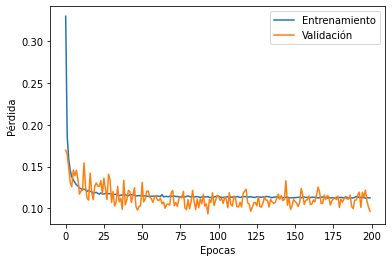

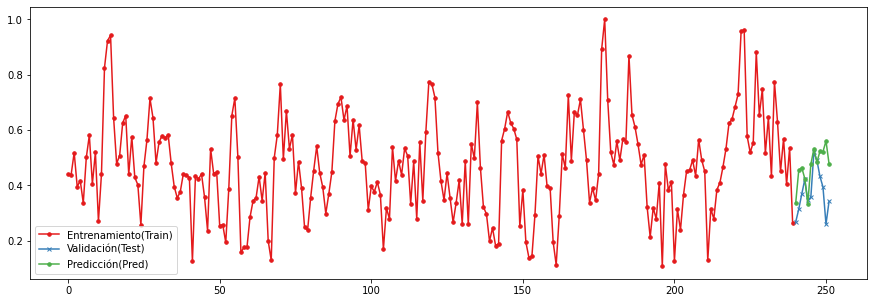

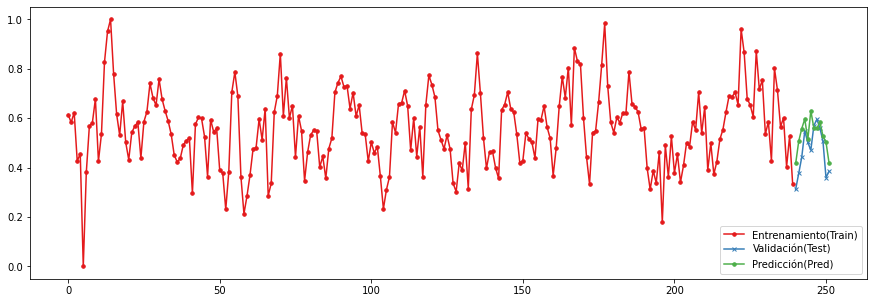

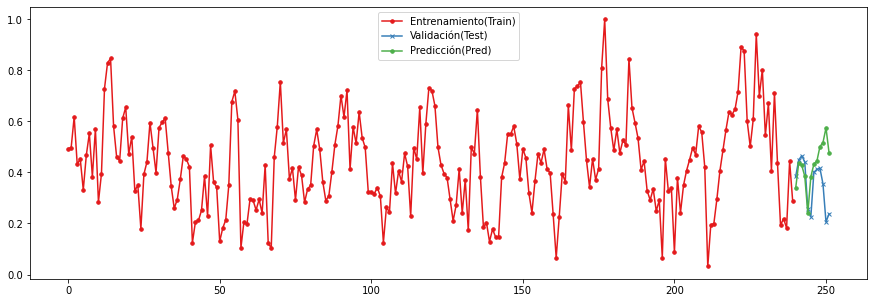

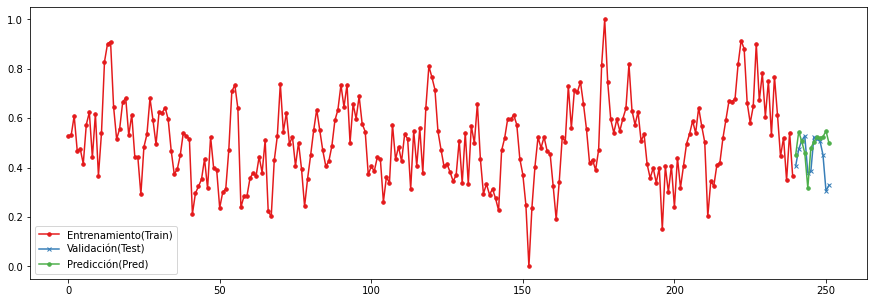

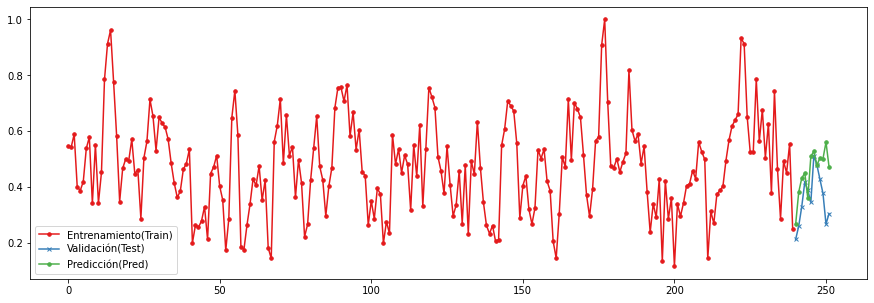

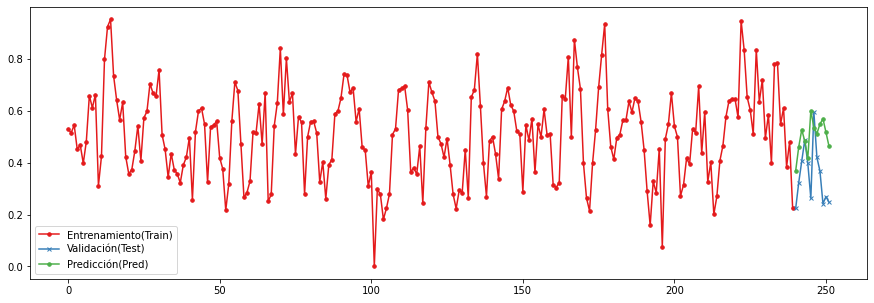

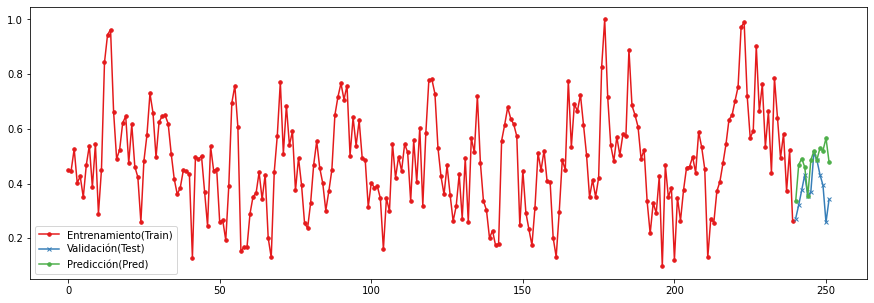

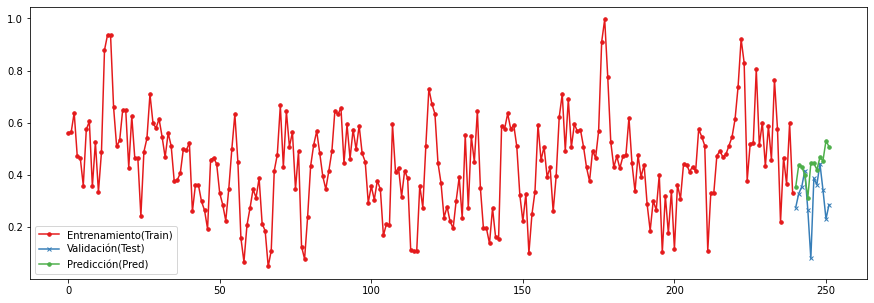

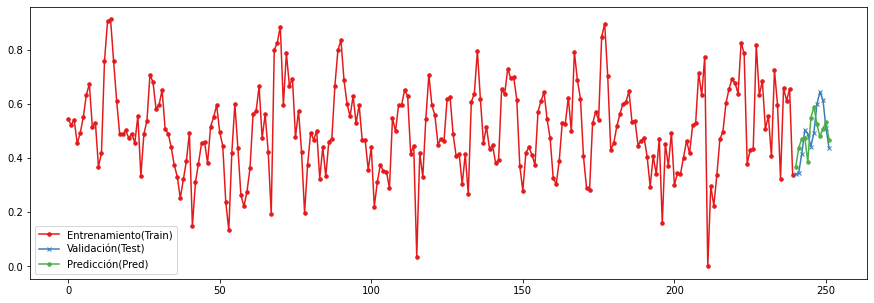

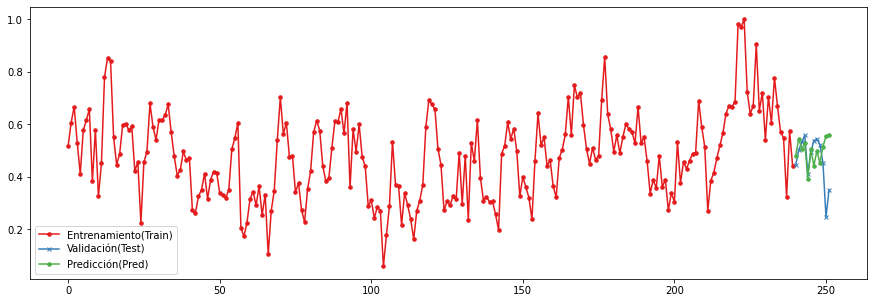

In [ ]:
inp = Input(shape=x_train.shape[-2:])
x = Flatten()(inp)
x = Dense(128)(x)
x = Dense(64)(x)
x = Dense(32)(x)
x = Dense(hpred)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss=error)
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=tbatch,
          epochs=epocas,
          verbose=1,
          validation_data=(x_test, y_test))
# Graficas de entrenamiento y validación
plt.figure()
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación'])

predicciones = model.predict(x_test)
mae = mean_absolute_error(y_test, predicciones)
resultados['MAE']['MLP'] = mae
resultados['Y_PRED']['MLP'] = predicciones
print(pd.DataFrame(resultados)['MAE'])

for x, y, y_pred in zip(x_test, y_test, predicciones):
  plotear(x,y,y_pred)

# Memoria a corto y largo plazo LSTM (Long-Short Term MemoryNeural Network )

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 240, 1)]          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_13 (Dense)             (None, 12)                780       
Total params: 17,676
Trainable params: 17,676
Non-trainable params: 0
_________________________________________________________________
Train on 4550 samples, validate on 10 samples
Epoch 1/200
4550/4550 [==============================] - 4s 854us/sample - loss: 0.2341 - val_loss: 0.1121
Epoch 2/200
4550/4550 [==============================] - 2s 428us/sample - loss: 0.1454 - val_loss: 0.1355
Epoch 3/200
4550/4550 [==============================] - 2s 421us/sample - loss: 0.1441 - val_loss: 0.1096
Epoch 4/200
4550/4

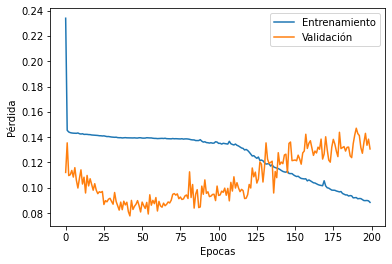

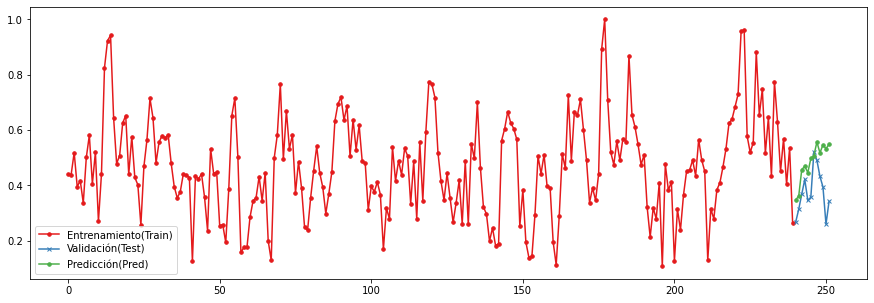

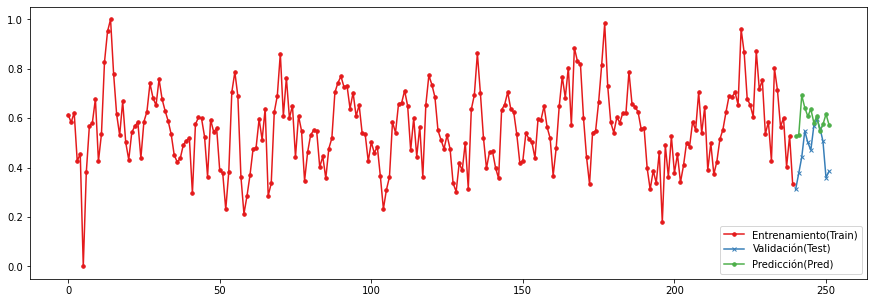

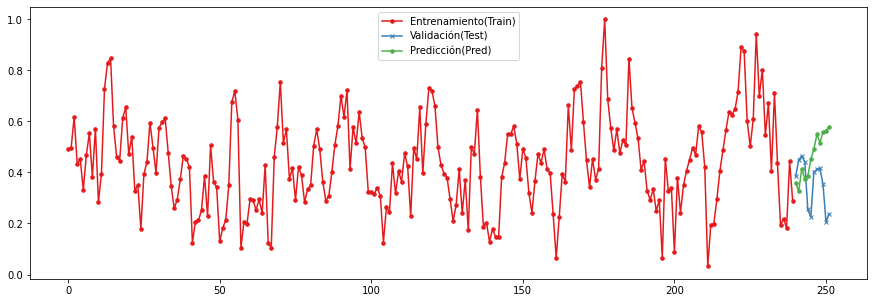

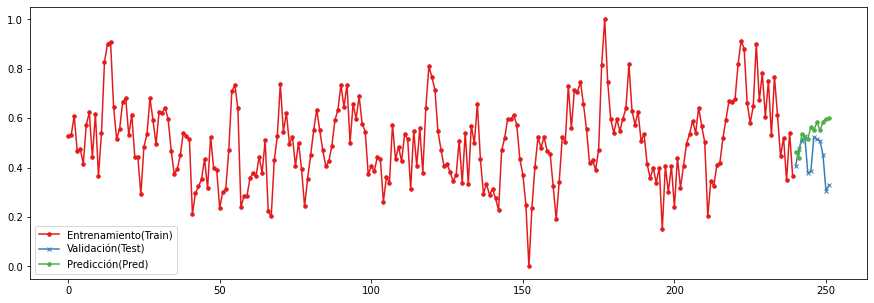

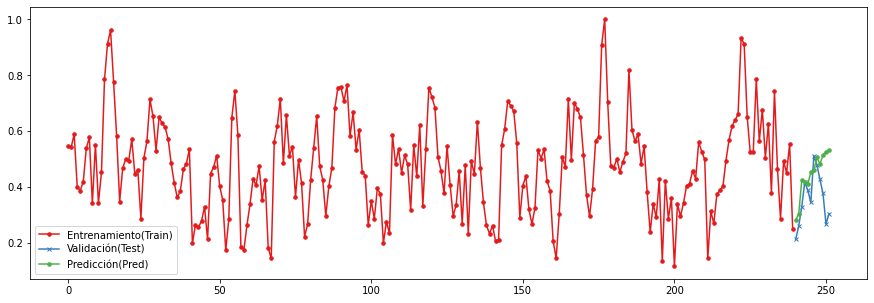

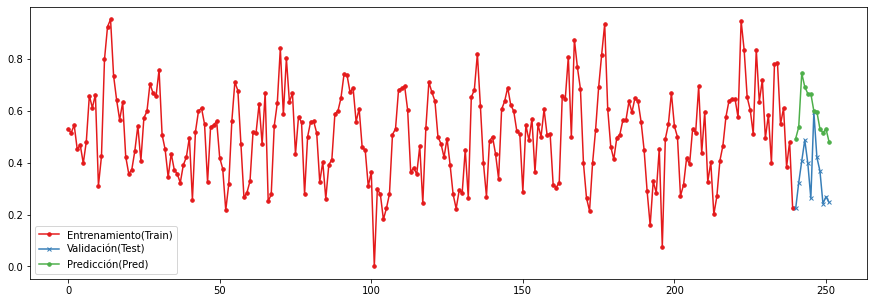

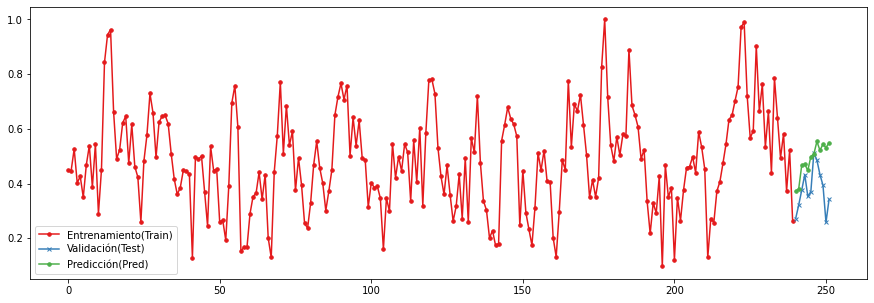

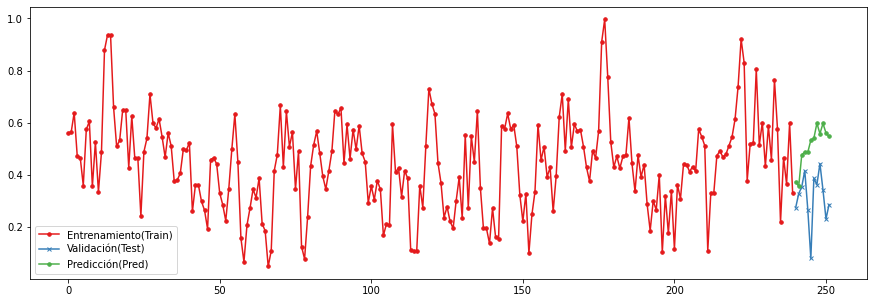

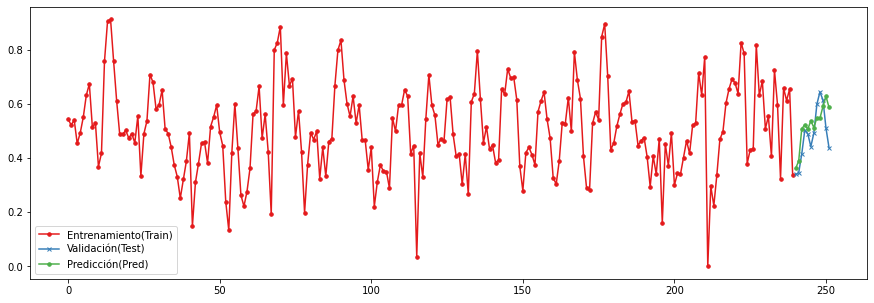

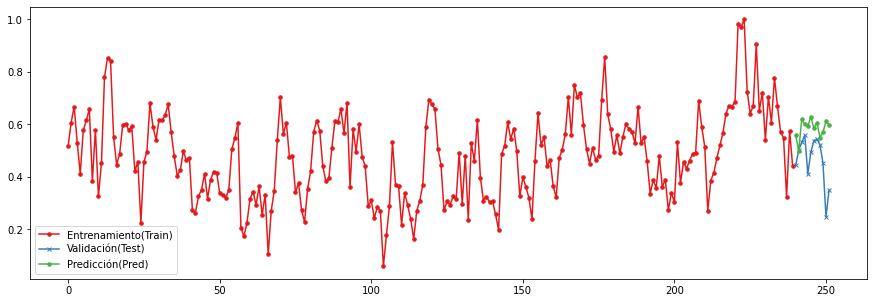

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, LSTM, Input
# Se crea un modelo LSTM con 64 units
inp = Input(shape=x_train.shape[-2:])
x = LSTM(64)(inp)
x = Dense(hpred)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss=error)
model.summary()
Input(shape=x_train.shape[-2:])
#Modelo con una capa
history = model.fit(x_train, y_train,
          batch_size=tbatch,
          epochs=epocas,
          verbose=1,
          validation_data=(x_test, y_test))
# Graficas de entrenamiento y validación
plt.figure()
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación'])
plt.show()
predicciones = model.predict(x_test)
mae = mean_absolute_error(y_test, predicciones)
resultados['MAE']['SimpleLSTM'] = mae
resultados['Y_PRED']['SimpleLSTM'] = predicciones
pd.DataFrame(resultados)['MAE']
for x, y, y_pred in zip(x_test, y_test, predicciones):
  plotear(x,y,y_pred)

# Red Recurrente LSTM con varias capas

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 240, 1)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 240, 64)           16896     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_15 (Dense)             (None, 12)                780       
Total params: 32,204
Trainable params: 32,204
Non-trainable params: 0
_________________________________________________________________
None
Train on 4550 samples, validate on 10 samples
Epoch 1/200
4550/4550 [==============================] - 6s 1ms/sample

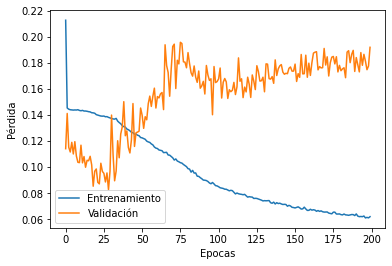

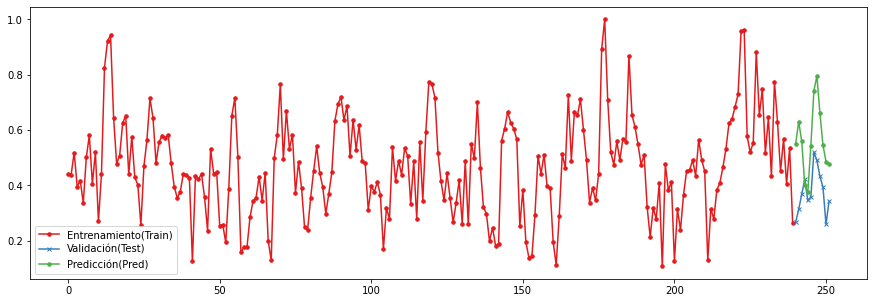

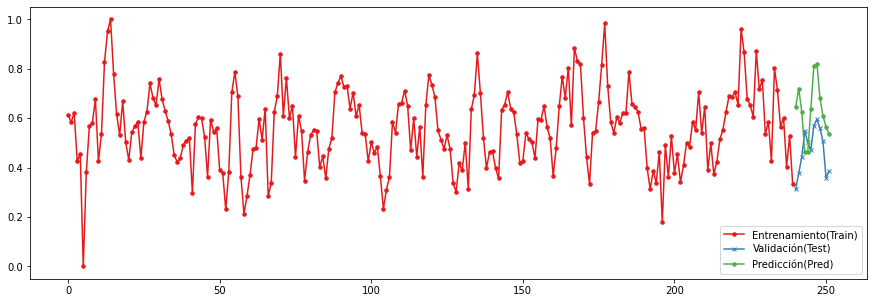

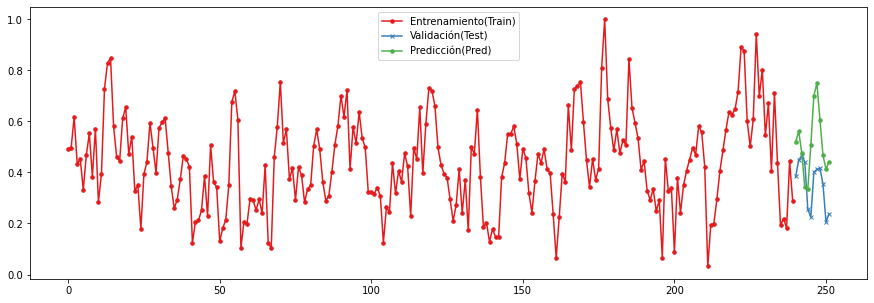

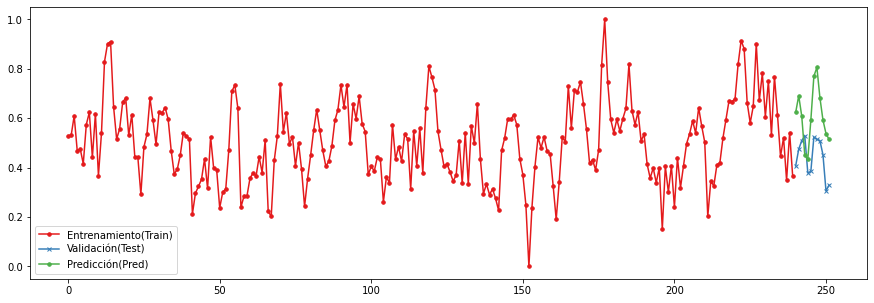

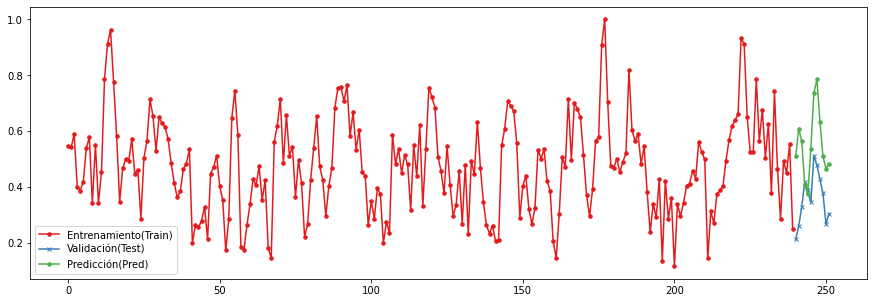

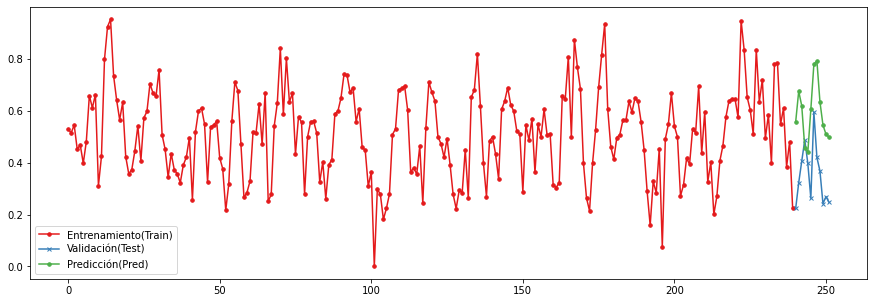

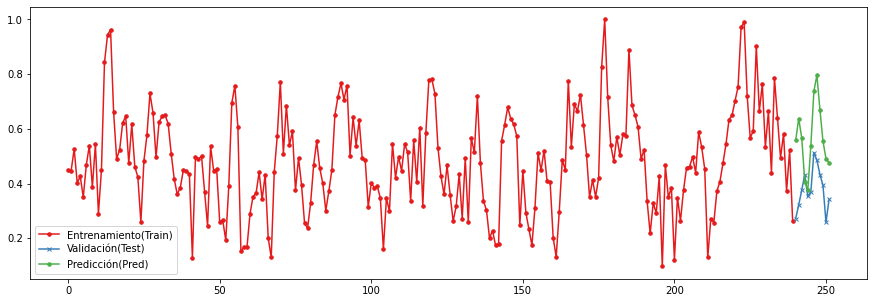

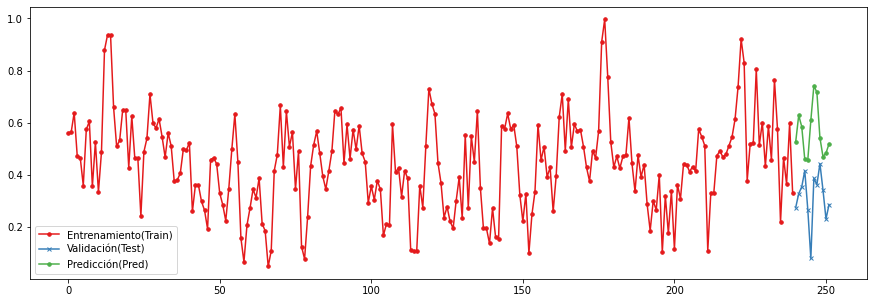

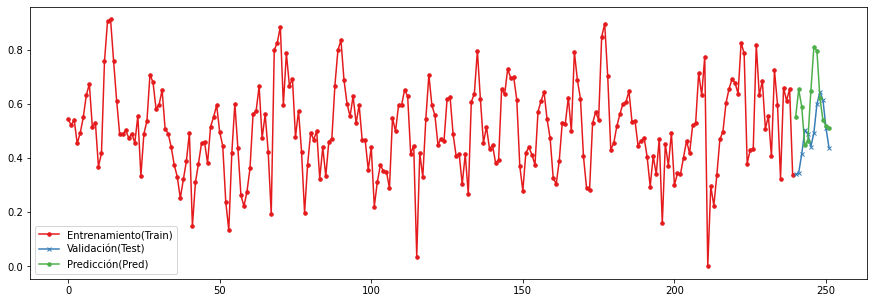

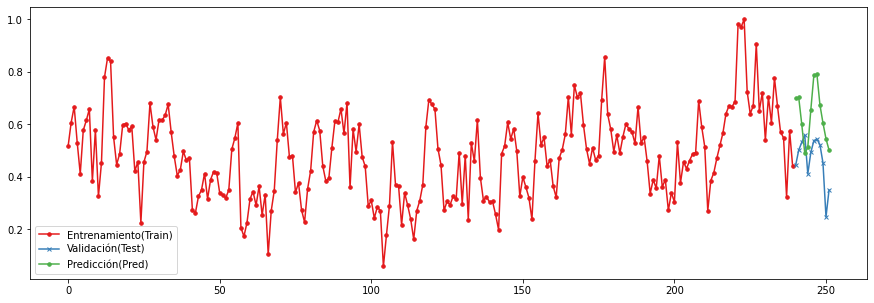

In [ ]:
# tbatch=128
# epocas=125

# También se pueden generar modelos más sofisticados aplicando varias capas LSTM, una sobre otra. 
inp = Input(shape=x_train.shape[-2:])
x = LSTM(64, return_sequences=True)(inp)
x = LSTM(32, return_sequences=False)(x)
x = Dense(64)(x)
x = Dense(hpred)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss=error)
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=tbatch,
          epochs=epocas,
          verbose=1,
          validation_data=(x_test, y_test))

# Graficas de entrenamiento y validación
plt.figure()
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación'])

predicciones = model.predict(x_test)
mae = mean_absolute_error(y_test, predicciones)
resultados['MAE']['LSTM'] = mae
resultados['Y_PRED']['LSTM'] = predicciones
print(pd.DataFrame(resultados)['MAE'])

for x, y, y_pred in zip(x_test, y_test, predicciones):
  plotear(x,y,y_pred)

 # Red Recurrente GRU 

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 240, 1)]          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 240, 128)          50304     
_________________________________________________________________
gru_3 (GRU)                  (None, 240, 64)           37248     
_________________________________________________________________
flatten_3 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                983104    
_________________________________________________________________
dense_17 (Dense)             (None, 12)                780       
Total params: 1,071,436
Trainable params: 1,071,436
Non-trainable params: 0
_________________________________________________

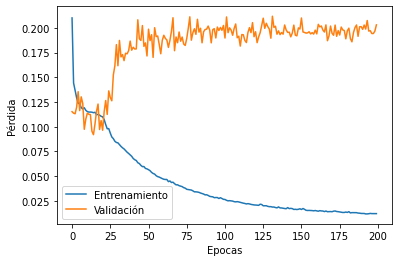

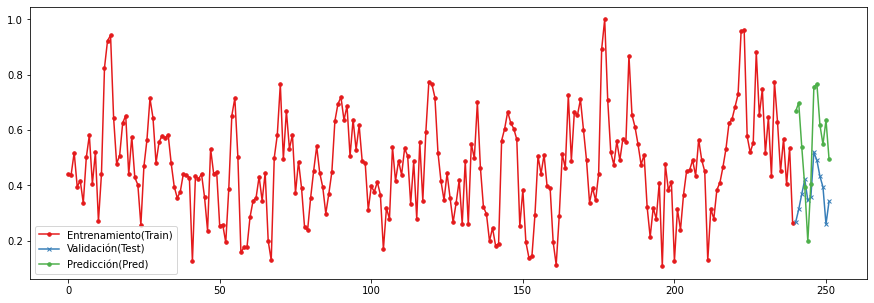

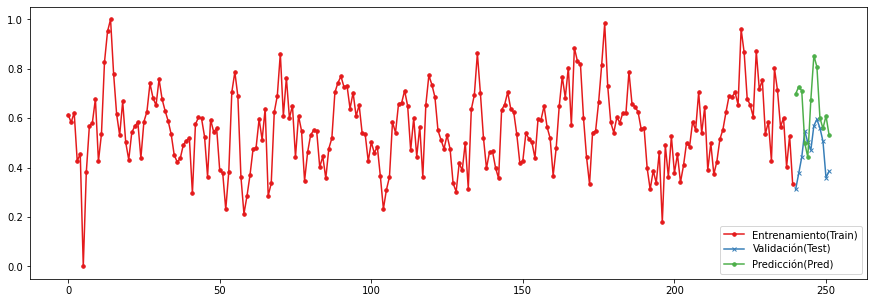

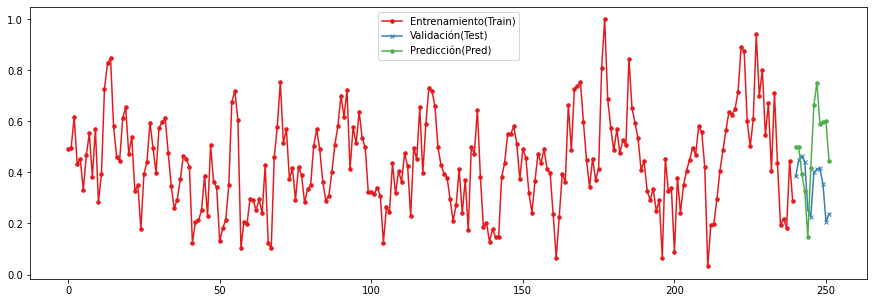

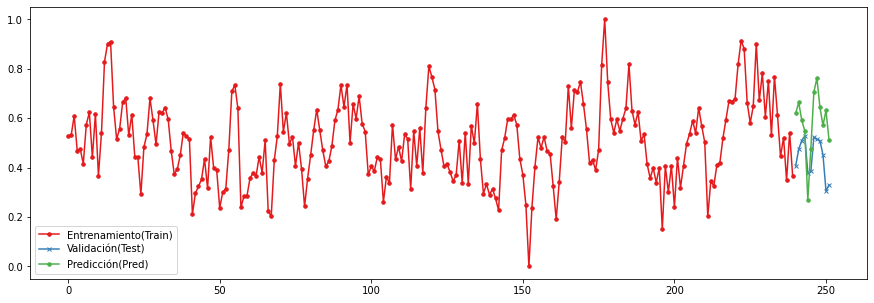

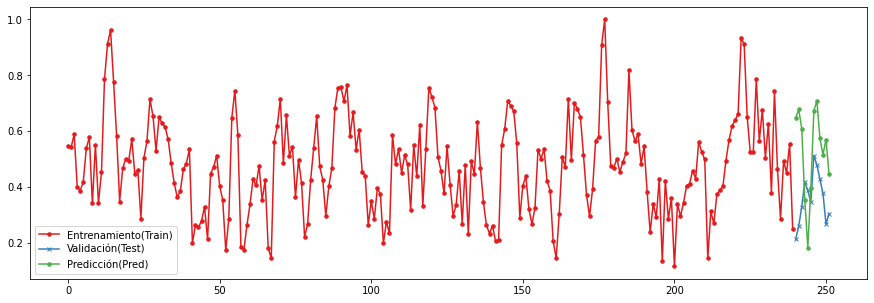

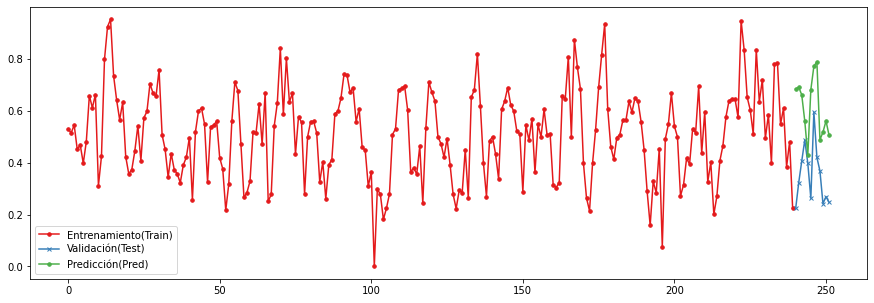

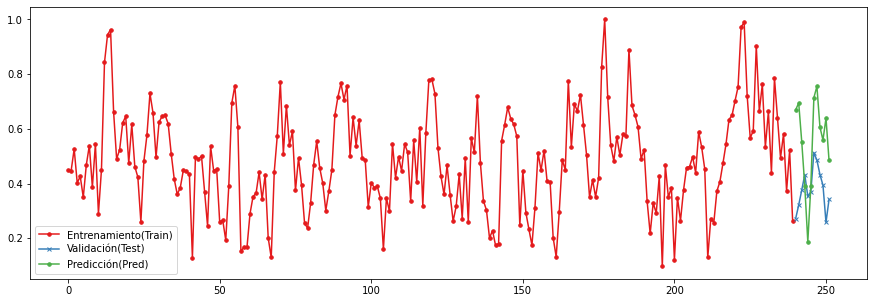

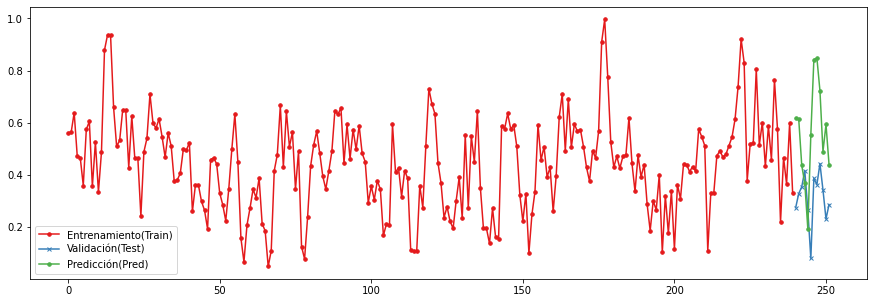

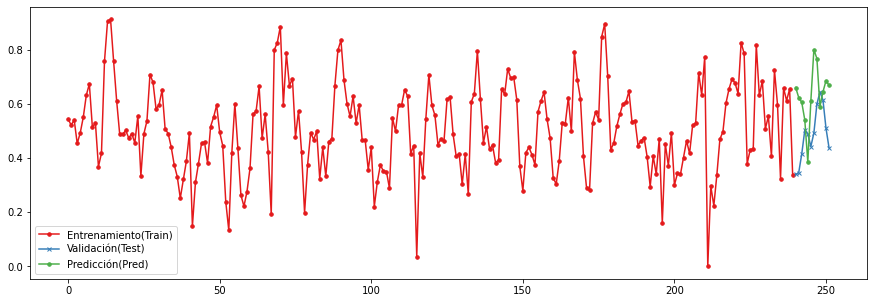

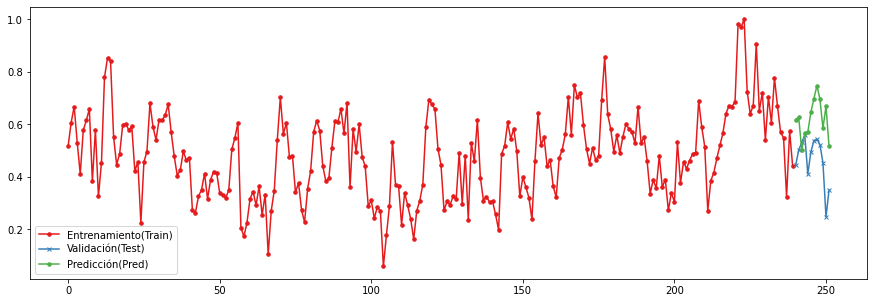

In [ ]:
# tbatch=128
# epocas=130

inp = Input(shape=x_train.shape[-2:])
x = GRU(128, return_sequences=True)(inp)
x = GRU(64, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(64)(x)
x = Dense(hpred)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss=error)
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=tbatch,
          epochs=epocas,
          verbose=1,
          validation_data=(x_test, y_test))

# Graficas de entrenamiento y validación
plt.figure()
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación'])

predicciones = model.predict(x_test)
mae = mean_absolute_error(y_test, predicciones)
resultados['MAE']['GRU'] = mae
resultados['Y_PRED']['GRU'] = predicciones
print(pd.DataFrame(resultados)['MAE'])

for x, y, y_pred in zip(x_test, y_test,predicciones):
 plotear(x,y,y_pred)

#  Red Convolucional CNN (Convolutional Neural Network)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 240, 1)]          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 240, 64)           384       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 120, 64)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 12)                92172     
Total params: 92,556
Trainable params: 92,556
Non-trainable params: 0
_________________________________________________________________
None
Train on 4550 samples, validate on 10 samples
Epoch 1/200
4550/4550 [==============================] - 1s 259us/samp

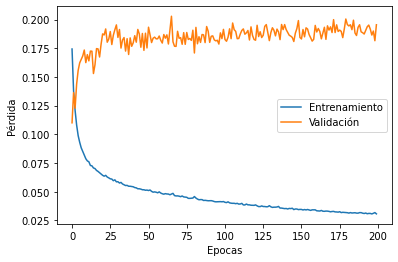

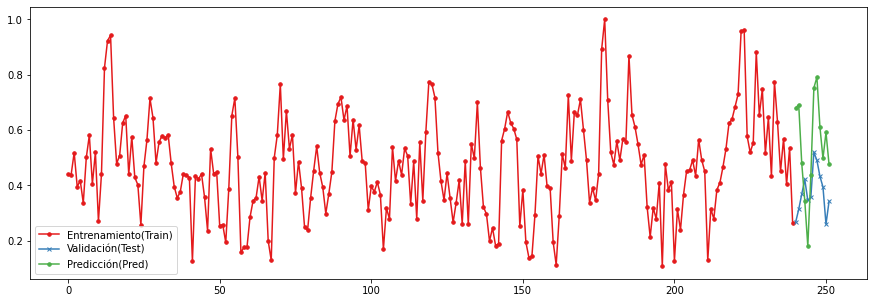

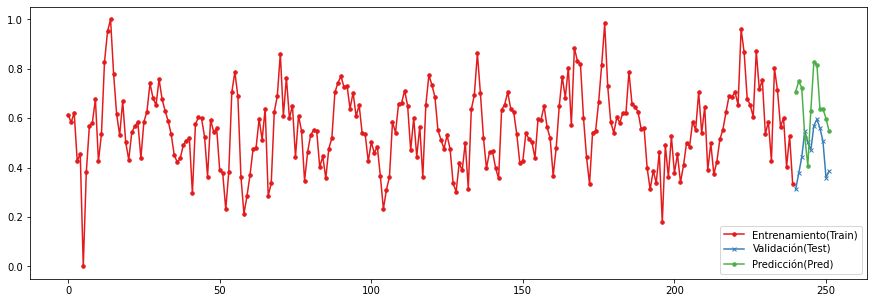

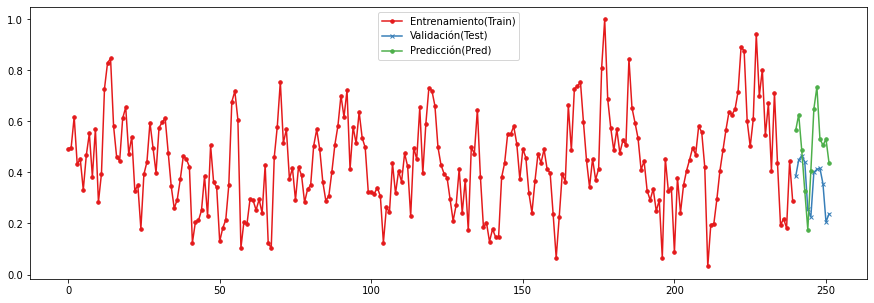

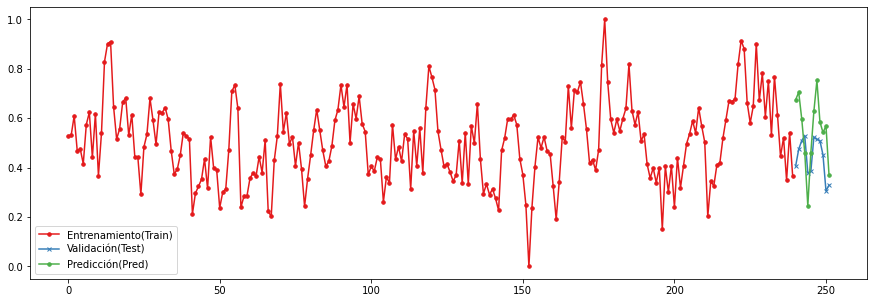

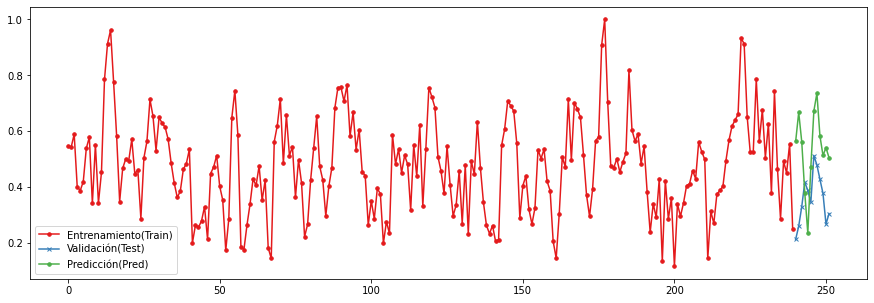

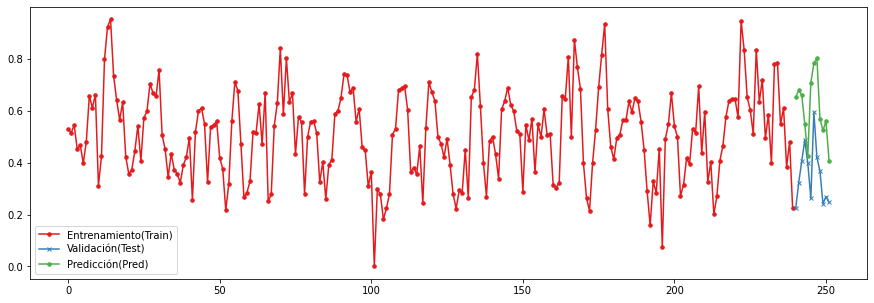

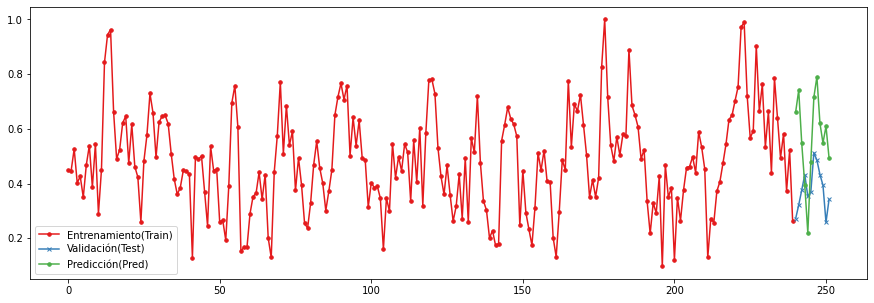

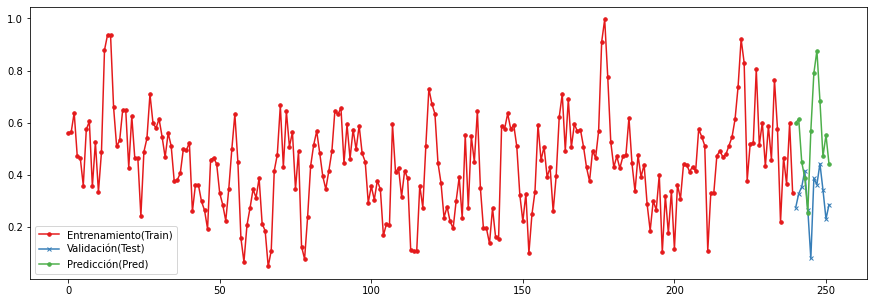

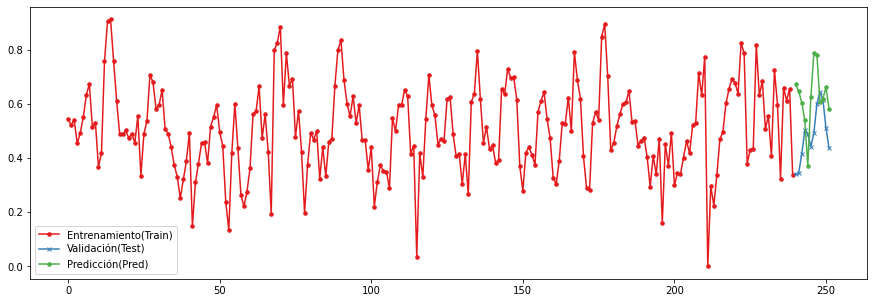

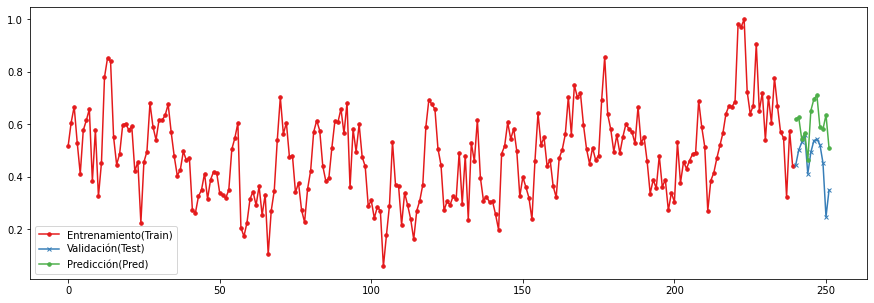

In [ ]:
# tbatch=128
# epocas=110

inp = Input(shape=x_train.shape[-2:])
x = Conv1D(128, 7, activation='relu', padding='same')(inp)
x = MaxPool1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same')(inp)
x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(hpred)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss=error)
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=tbatch,
          epochs=epocas,
          verbose=1,
          validation_data=(x_test, y_test))

# Graficas de entrenamiento y validación
plt.figure()
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación'])

predicciones = model.predict(x_test)
mae = mean_absolute_error(y_test, predicciones)
resultados['MAE']['CNN'] = mae
resultados['Y_PRED']['CNN'] = predicciones
print(pd.DataFrame(resultados)['MAE'])

for x, y, y_pred in zip(x_test, y_test, predicciones):
  plotear(x,y,y_pred)

#  Red Convolucional TCN(Temporal Convolutional Network)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 240, 1)]          0         
_________________________________________________________________
tcn (TCN)                    (None, 64)                160960    
_________________________________________________________________
dense_19 (Dense)             (None, 12)                780       
Total params: 161,740
Trainable params: 161,740
Non-trainable params: 0
_________________________________________________________________
None
Train on 4550 samples, validate on 10 samples
Epoch 1/200
4550/4550 [==============================] - 8s 2ms/sample - loss: 1.2510 - val_loss: 0.2636
Epoch 2/200
4550/4550 [==============================] - 3s 679us/sample - loss: 0.2232 - val_loss: 0.1943
Epoch 3/200
4550/4550 [==============================] - 3s 690us/sample - loss: 0.1724 - val_loss: 0.1286
Epoch 4/200
4

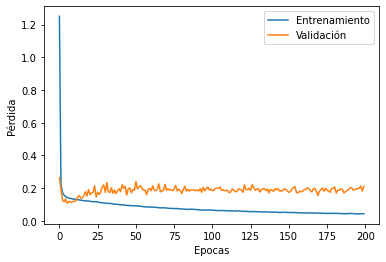

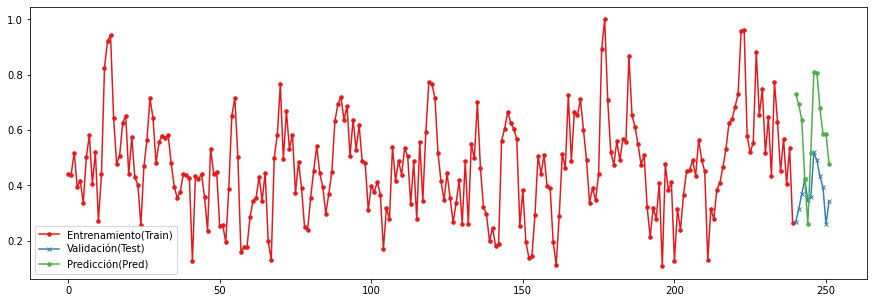

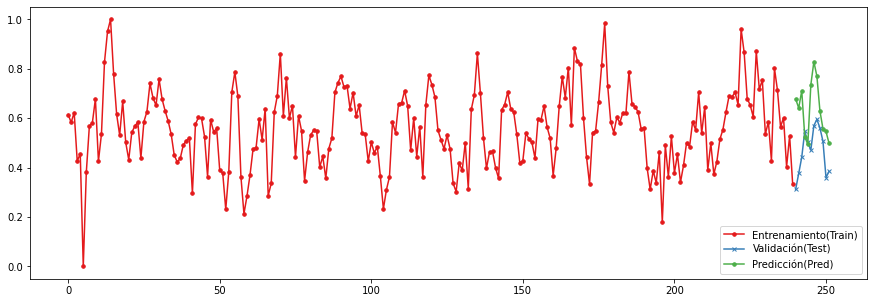

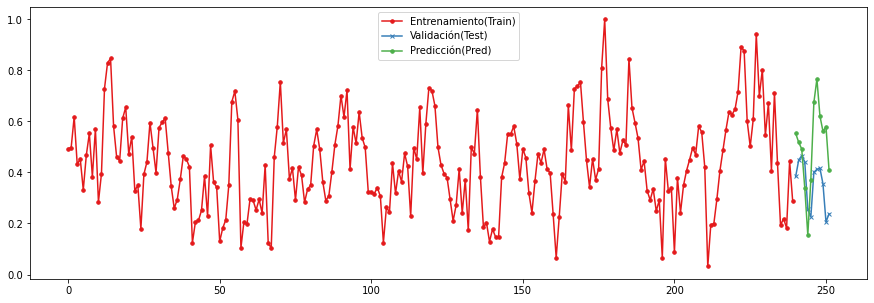

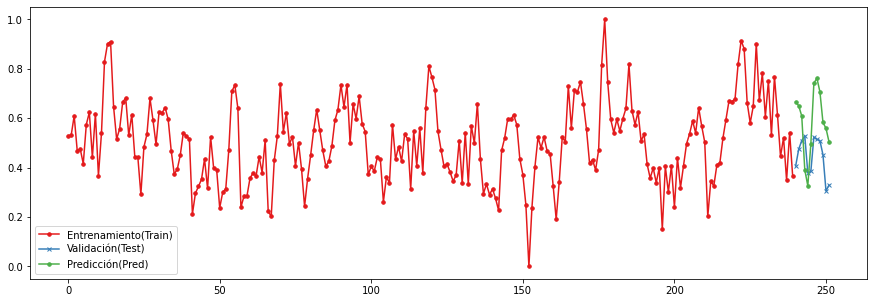

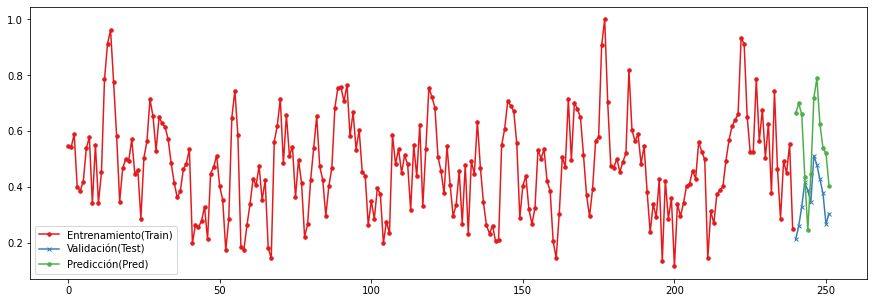

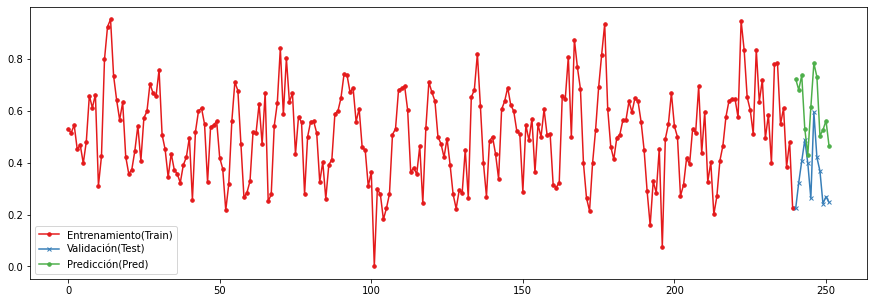

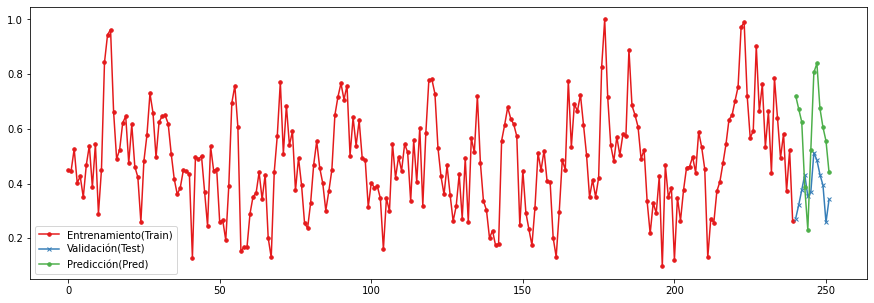

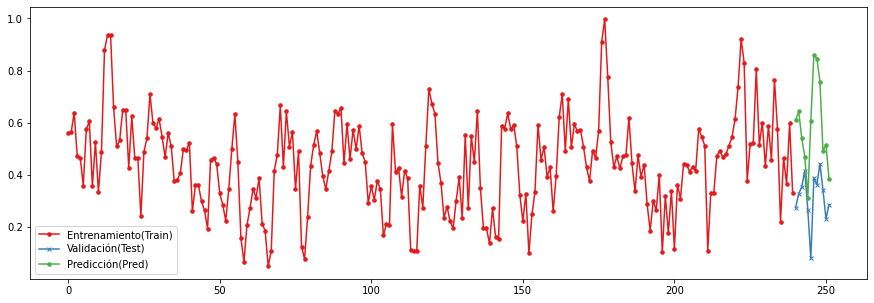

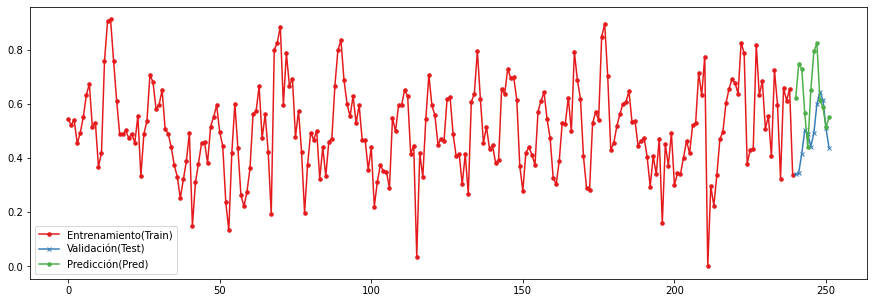

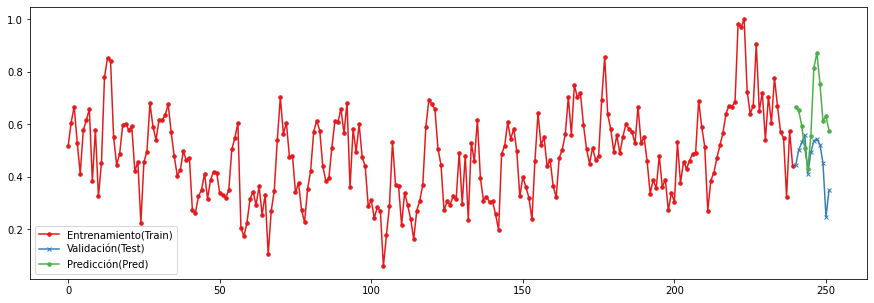

In [ ]:
# tbatch=128
# epocas=180

inp = Input(shape=x_train.shape[-2:])
x = TCN(nb_filters=64, kernel_size=3, nb_stacks=1, dilations=[1,2,4,8,16,32,64])(inp)
x = Dense(hpred)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss=error)
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=tbatch,
          epochs=epocas,
          verbose=1,
          validation_data=(x_test, y_test))

# Graficas de entrenamiento y validación
plt.figure()
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación'])

predicciones = model.predict(x_test)
mae = mean_absolute_error(y_test, predicciones)
resultados['MAE']['TCN'] = mae
resultados['Y_PRED']['TCN'] = predicciones
print(pd.DataFrame(resultados)['MAE'])

for x, y, y_pred in zip(x_test, y_test, predicciones):
 plotear(x,y,y_pred)

Fuente: Basado en el documento de :  Manuel Carranza-García 
https://github.com/carranza96/DLSeminar/tree/master/notebooks